# **Hands-On Machine Learning Project**
## **Topic 20: Credit Data**
### Florian Korn, Vincent Bläske, Dennis Götz

***
# **Table of Content**
**[V. Shortlist Models](#shortlist)**<br>
***

## **V. Shortlist Models**  <a id='shortlist'></a>
**[1. Feature Selection and Encoding Pipes](#fsep)**<br>
**[2. Create Train and Test Set](#traintest)**<br>
**[3. Train models with standard parameters](#quickdirty)**<br>
**[4. Fine Tuneing](#finetune)**<br>

To Do:<br>
3. Analyze the most significant variables for each algorithm (e.g., the features with the largest coefficients in a linear regression model).<br>
4. Analyze the types of errors the models make: What data would a human have used to avoid these errors?<br>
5. Perform a quick round of feature selection and engineering.<br>
6. Perform one or two more quick iterations of the five previous steps.<br>
7. Shortlist the top three to five most promising models, preferring models that make different types of errors.
***
### **Import of librariers:**

In [3]:
import pandas as pd
from pandas import get_dummies
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, linear_model, svm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

### **Load stored data:**

In [4]:
%store -r attributes
%store -r num_attribs
%store -r cat_attribs
%store -r binary_attribs
%store -r dict_ordinal_map
%store -r data_values
%store -r train_set
%store -r test_set

### **1. Feature Selection and Encoding Pipes** <a id='fsep'></a> <br> 
Here a pipe encoder and selector preprocesses the data.

In [12]:
def pipe_encoder_selector(df: pd.DataFrame(), dict_ordinal_map: dict, columns_excluded: list, cat_attribs: list, binary_attribs: list, num_attribs: list,  target: str, ordinal_encoding = True):
    '''
    This function allows to preprocess a DataFrame with a specific target variable and numerical as also categorical features (with a specific ordering)

    Parameters:
    df : a DataFrame we want to encode and do feature selection
    dict_ordinal_map : a dictionary with the ordered values of categories (specific order)
    columns_excluded : feature selection for the columns we don't want
    cat_attribs : all categorical attributes in our df
    binary_attribs : all binary attributes in our df
    num_attribs : all numerical attribs in our df
    target : target variable (only one possible)
    ordinal_encoding : if all categorical features should be encoded ordinal or one-hot-encoding

    Returns:
    Encoded DataFrame
    '''
    num_pipeline = make_pipeline(
        StandardScaler())
    
    if ordinal_encoding:
        column_cat = [i for i in cat_attribs if (i not in columns_excluded) and (i != target)]
        column_target = [target]
        categories_order = [dict_ordinal_map[i] for i in column_cat]
        cat_pipeline = make_pipeline( 
            OrdinalEncoder(dtype = 'int', categories = categories_order))
    else:
        column_cat = [i for i in cat_attribs if (i not in columns_excluded) and (i != target) and (i not in binary_attribs)]
        column_target = [i for i in cat_attribs if (i not in columns_excluded) and (i not in column_cat)]
        cat_pipeline = make_pipeline(
            OneHotEncoder(dtype = 'int'))
    
    target_pipeline = make_pipeline(
            OrdinalEncoder(dtype = 'int', categories = [dict_ordinal_map[i] for i in column_target]))

    preprocessing = make_column_transformer( 
        (num_pipeline, num_attribs), 
        (cat_pipeline, column_cat),
        (target_pipeline, column_target),
        remainder = 'drop', verbose_feature_names_out = False)

    X = preprocessing.fit_transform(df)
    df_encoded = pd.DataFrame(
                        X, 
                        columns = preprocessing.get_feature_names_out(),
                        index = df.index
                        )
    return df_encoded

columns_excluded = ['foreign worker', 'Personal status and sex']

### **2. Create Train and Test Set** <a id='traintest'></a> <br> 

In [16]:
# Separate features and target values in train and test set
train_set_ordinal_encoded = pipe_encoder_selector(train_set, dict_ordinal_map, columns_excluded, cat_attribs, binary_attribs, num_attribs, 'Credit rating', True)
test_set_ordinal_encoded = pipe_encoder_selector(test_set, dict_ordinal_map, columns_excluded, cat_attribs, binary_attribs, num_attribs, 'Credit rating', True)
X_train_ordinal = np.array(train_set_ordinal_encoded.iloc[:, :-1])
y_train_ordinal = np.array(train_set_ordinal_encoded.iloc[:, -1])
X_test_ordinal = np.array(test_set_ordinal_encoded.iloc[:, :-1])
y_test_ordinal = np.array(test_set_ordinal_encoded.iloc[:, -1])

# Separate features and target values in train and test set
train_set_onehot_encoded = pipe_encoder_selector(train_set, dict_ordinal_map, columns_excluded, cat_attribs, binary_attribs, num_attribs, 'Credit rating', False)
test_set_onehot_encoded = pipe_encoder_selector(test_set, dict_ordinal_map, columns_excluded, cat_attribs, binary_attribs, num_attribs, 'Credit rating', False)
X_train_onehot = np.array(train_set_onehot_encoded.iloc[:, :-1])
y_train_onehot = np.array(train_set_onehot_encoded.iloc[:, -1])
X_test_onehot = np.array(test_set_onehot_encoded.iloc[:, :-1])
y_test_onehot = np.array(test_set_onehot_encoded.iloc[:, -1])

display(train_set.head(3))
display(train_set_ordinal_encoded.head(3))
display(train_set_onehot_encoded.head(3))

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Credit rating
355,0 <= ... < 200 DM,24,existing credits paid back duly till now,car (new),1246,... < 100 DM,... < 1 year,4,male : single,none,...,real estate,23,stores,own,1,unskilled - resident,1,none,yes,bad
661,... < 0 DM,12,existing credits paid back duly till now,car (new),900,unknown/ no savings account,1 <= ... < 4 years,4,male : married/widowed,none,...,"car or other, not in attribute 6",23,none,own,1,skilled employee / official,1,none,yes,bad
300,no checking account,6,existing credits paid back duly till now,car (new),672,... < 100 DM,unemployed,1,female : divorced/separated/married,none,...,real estate,54,none,own,1,unemployed/ unskilled - non-resident,1,"yes, registered under the customers name",yes,good


,Age in years,Number of existing credits at this bank,Installment rate in percentage of disposable income,Present residence since,Duration in month,Credit amount,Number of people being liable to provide maintenance for,Status of existing checking account,Credit history,Purpose,Savings account/bonds,Present employment since,Other debtors / guarantors,Property,Other installment plans,Housing,Job,Telephone,Credit rating
355,-1.084571,-0.712435,0.918837,-0.785979,0.257194,-0.721798,-0.411814,2.0,2.0,0.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0,1.0,1.0
661,-1.084571,-0.712435,0.918837,-0.785979,-0.743643,-0.846553,-0.411814,1.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,1.0,1.0
300,1.618410,-0.712435,-1.757388,1.033944,-1.244061,-0.928761,-0.411814,0.0,2.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0


,Age in years,Number of existing credits at this bank,Installment rate in percentage of disposable income,Present residence since,Duration in month,Credit amount,Number of people being liable to provide maintenance for,Status of existing checking account_... < 0 DM,Status of existing checking account_... >= 200 DM / salary assignments for at least 1 year,Status of existing checking account_0 <= ... < 200 DM,...,Other installment plans_stores,Housing_for free,Housing_own,Housing_rent,Job_management/ self-employed/ highly qualified employee/ officer,Job_skilled employee / official,Job_unemployed/ unskilled - non-resident,Job_unskilled - resident,Telephone,Credit rating
355,-1.084571,-0.712435,0.918837,-0.785979,0.257194,-0.721798,-0.411814,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
661,-1.084571,-0.712435,0.918837,-0.785979,-0.743643,-0.846553,-0.411814,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
300,1.618410,-0.712435,-1.757388,1.033944,-1.244061,-0.928761,-0.411814,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### **3. Train models with standard parameters** <a id='quickdirty'></a> <br>
Create the Pipelines with the quick and dirty models.

In [18]:
# Create Pipelines

# Linear Models
## Linear Regression
pipe_reg = Pipeline([('reg', LinearRegression())])

## Ridge Regression
pipe_ridgereg = Pipeline([('scaler', StandardScaler()),
                          ('ridgereg', linear_model.Ridge())])

## Lasso Regression
pipe_lassoreg = Pipeline([('scaler', StandardScaler()),
                          ('lassoreg', linear_model.Lasso())])

## Logistic Regression
pipe_logreg = Pipeline([('scaler', StandardScaler()),
                        ('logreg', LogisticRegression())])

# kNN
pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())])

# naiveBayes
pipe_gaussiannb = Pipeline([('gaussiannb', GaussianNB())])

# Support Vector Machine
pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('svm', svm.SVC())])

# Random Forest
pipe_rf = Pipeline([('rf', RandomForestClassifier())])

# Decision Tree
pipe_decisiontree = Pipeline([('decisiontree', tree.DecisionTreeClassifier())])

# Neural Network Classifier
pipe_neuralnetwork = Pipeline([('scaler', StandardScaler()),
                               ('neuralnetwork', MLPClassifier())])


Compute the scores of the pipelines with the quick and dirty models.

For ordinal encoded data:


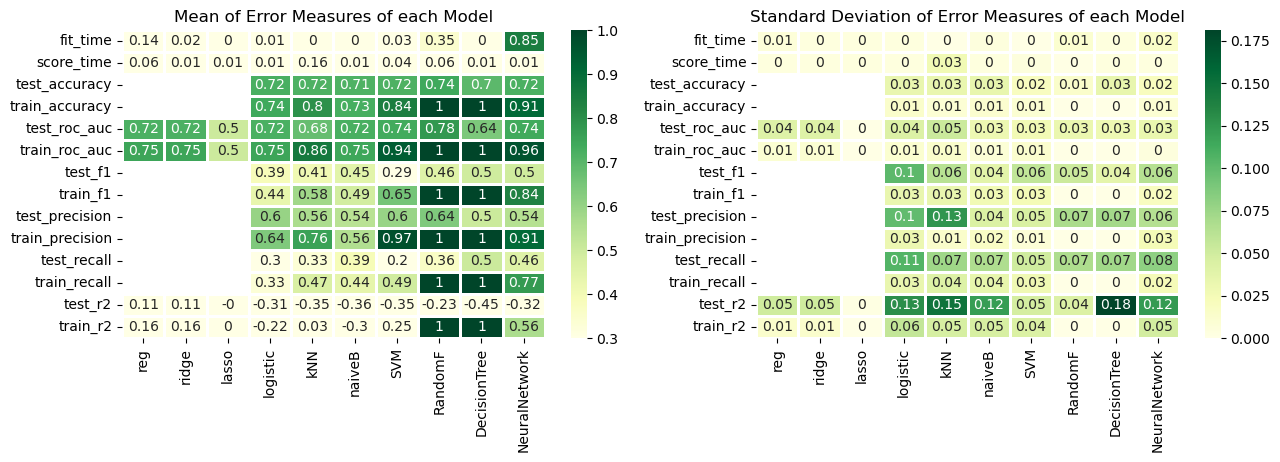

For one-hot encoded data:


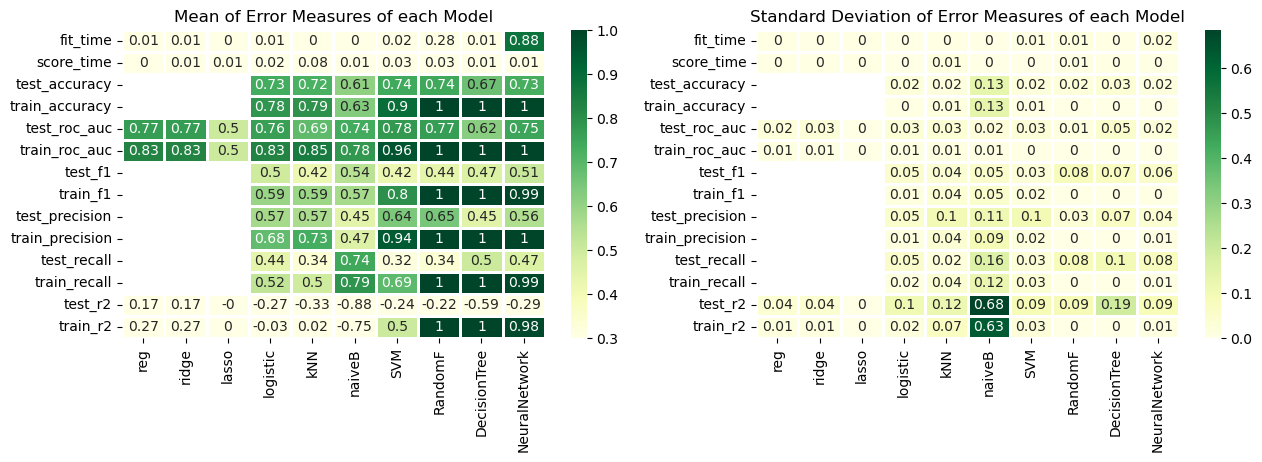

In [19]:
# K Fold iterator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# List of pipelines
pipeline_list = [pipe_reg,
                 pipe_ridgereg,
                 pipe_lassoreg,
                 pipe_logreg,
                 pipe_knn,
                 pipe_gaussiannb,
                 pipe_svm,
                 pipe_rf,
                 pipe_decisiontree,
                 pipe_neuralnetwork]

# compute scores of quick and dirty models
def score_quick_models(X_train, y_train, pipeline_list):
    '''
    This function computes the error measures of quick and dirty models.

    Parameters:
    X_train : the training data with all features
    y_train : the training data with the target variable
    pipeline_list : all pipelines

    Returns:
    Two heatmaps with the mean and standard deviation of the error measures
    '''
    scores_mean = pd.concat([pd.DataFrame(pd.DataFrame(cross_validate(pipeline_list[i], 
                                                                X_train,
                                                                y_train,
                                                                scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'],
                                                                cv=kfold,
                                                                n_jobs=-1,
                                                                return_train_score=True)).mean(), columns = [i]) for i in range(len(pipeline_list))], axis = 1)
    scores_std = pd.concat([pd.DataFrame(pd.DataFrame(cross_validate(pipeline_list[i], 
                                                                X_train,
                                                                y_train,
                                                                scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'],
                                                                cv=kfold,
                                                                n_jobs=-1,
                                                                return_train_score=True)).std(), columns = [i]) for i in range(len(pipeline_list))], axis = 1)
    scores_mean.columns = ['reg', 'ridge', 'lasso', 'logistic', 'kNN', 'naiveB', 'SVM', 'RandomF', 'DecisionTree', 'NeuralNetwork']
    scores_std.columns = ['reg', 'ridge', 'lasso', 'logistic', 'kNN', 'naiveB', 'SVM', 'RandomF', 'DecisionTree', 'NeuralNetwork']

    # Visualize scores
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,4))
    g1 = sns.heatmap(scores_mean, vmin = 0.3, vmax = 1, center = 0.65, linewidth = 1, linecolor = 'white', cmap = 'YlGn', annot = np.round(scores_mean, 2), ax = ax1)
    ax1.title.set_text('Mean of Error Measures of each Model')
    g2 = sns.heatmap(scores_std, linewidth = 1, linecolor = 'white', cmap = 'YlGn', annot = np.round(scores_std, 2), ax = ax2)
    ax2.title.set_text('Standard Deviation of Error Measures of each Model')
    plt.show()

print('For ordinal encoded data:')
score_quick_models(X_train_ordinal, y_train_ordinal, pipeline_list)
print('For one-hot encoded data:')
score_quick_models(X_train_onehot, y_train_onehot, pipeline_list)

When we look at the scores to identify the most promising models, one should weight the importance of the scores on the test set higher than on the train set.<br> 
The R2 is a great error measure for continous predictions, as in regression tasks, therefore it shouldn't be of interest in models which have a categorical outcome.<br>
It is <u>worse to classify a customer as good (0) when they are bad (1)</u> than it is to classify a customer as bad when they are good (1). The metrics that describe this well are recall (the proportion of true positives among all positives) and roc auc, which describes the area under the curve; if it is 1, we separate the classes perfectly and therefore identify true positives with a very high probability.<br>

#### **Overall**
Between the error measures of the one-hot encoded data and the ordinal encoded data, we see that the neural network and SVM performs better in terms of mean error when one-hot encoded.
* <u>Mean of the error measures</u>
    * Ordinal encoded (three best models)
        * Roc_auc on the test data: 
            * Random Forest
            * SVM
            * Neural Network
        * Recall on the test data: 
            * Decision Tree
            * Neural Network
            * Naive Bayes
    * One-hot-encoded (three best models)
        * Roc_auc on the test data: 
            * SVM
            * Random Forest
            * Logistic Regression
        * Recall on the test data:
            * Naive Bayes
            * Neural Network
            * Logistic Regression

* <u>Standard deviation of the error measures</u>
    * Ordinal encoded
        * Slightly higher compared to other models:
            * R2
                * Decision Tree
                * kNN
                * Logistic Regression
                * naive Bayes
                * Neural Network
            * Recall
                * Logistic Regression
            * Precision
                * kNN
    * One-hot-encoded
        * Highest compared to other models:
            * R2
                * SVM

### **Decision**
The most promising models to fine tune are:
* Ordinal encoded
    * Random Forest
    * SVM
    * Neural Network
    * Decision Tree
    * Naive Bayes
* One-hot-encoded
    * SVM
    * Random Forest
    * Logistic Regression
    * Naive Bayes
    * Neural Network
<br>

For the fine tuneing we suggest to look at the linear regression as a negative example. A positive outcome we think might bring SVM, Logistic Regression, Random Forest, Decision Tree

### **4. Fine Tuneing** <a id='finetune'></a> <br>